# EDSA

In [1]:
# Import the requisite packages
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd 
from libpysal.weights import Queen, KNN 
from esda.moran import Moran 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import robust_scale
import contextily as ctx

In [2]:
nm_merge2 = gpd.read_file('../../data/local/nm_census_2022.gpkg')

In [3]:
geo_demo_rn = [
"TotPop", #"Total Population"
"TotPopOccUnits", #"Total population in occupied housing units"
"TotNumOwnOccUnit", #"Total number of owner occupied units"
"TotNumRentOccUnit", #"Total number of renter occupied units"
"PopLTHSDip", #"Population with less than a high school diploma"
"PopHSDip", #"Population with high school diploma or equivalent"
"PopAssoc", #"Population with some college/associates degree"
"PopBA", #"Population with bachelors degree"
"PopGrad", #"Population with a graduate degree"
"PopIncLT10", #"Population with income less than 9999"
"PopInc1015", #"Population with income between 10000 and 14999"
"PopInc1525", #"Population with income between 15000 and 24999"
"PopInc2535", #"Population with income between 25000 and 34999"
"PopInc3550", #"Population with income between 35000 and 49999"
"PopInc5065", #"Population with income between 50000 and 64999"
"PopInc6575", #"Population with income between 65000 and 74999"
"PopIncGT75", #"Population with income of 75000 or more"
"UnempPop", #"Population in labor force and unemployed"
"RetPop", #"Population that is retired with retirement income"
"RetPopNoRetInc", #"Retired without retirement income"
"PopBlwPovLvl" #"Population with income below poverty level in past 12 months"
]

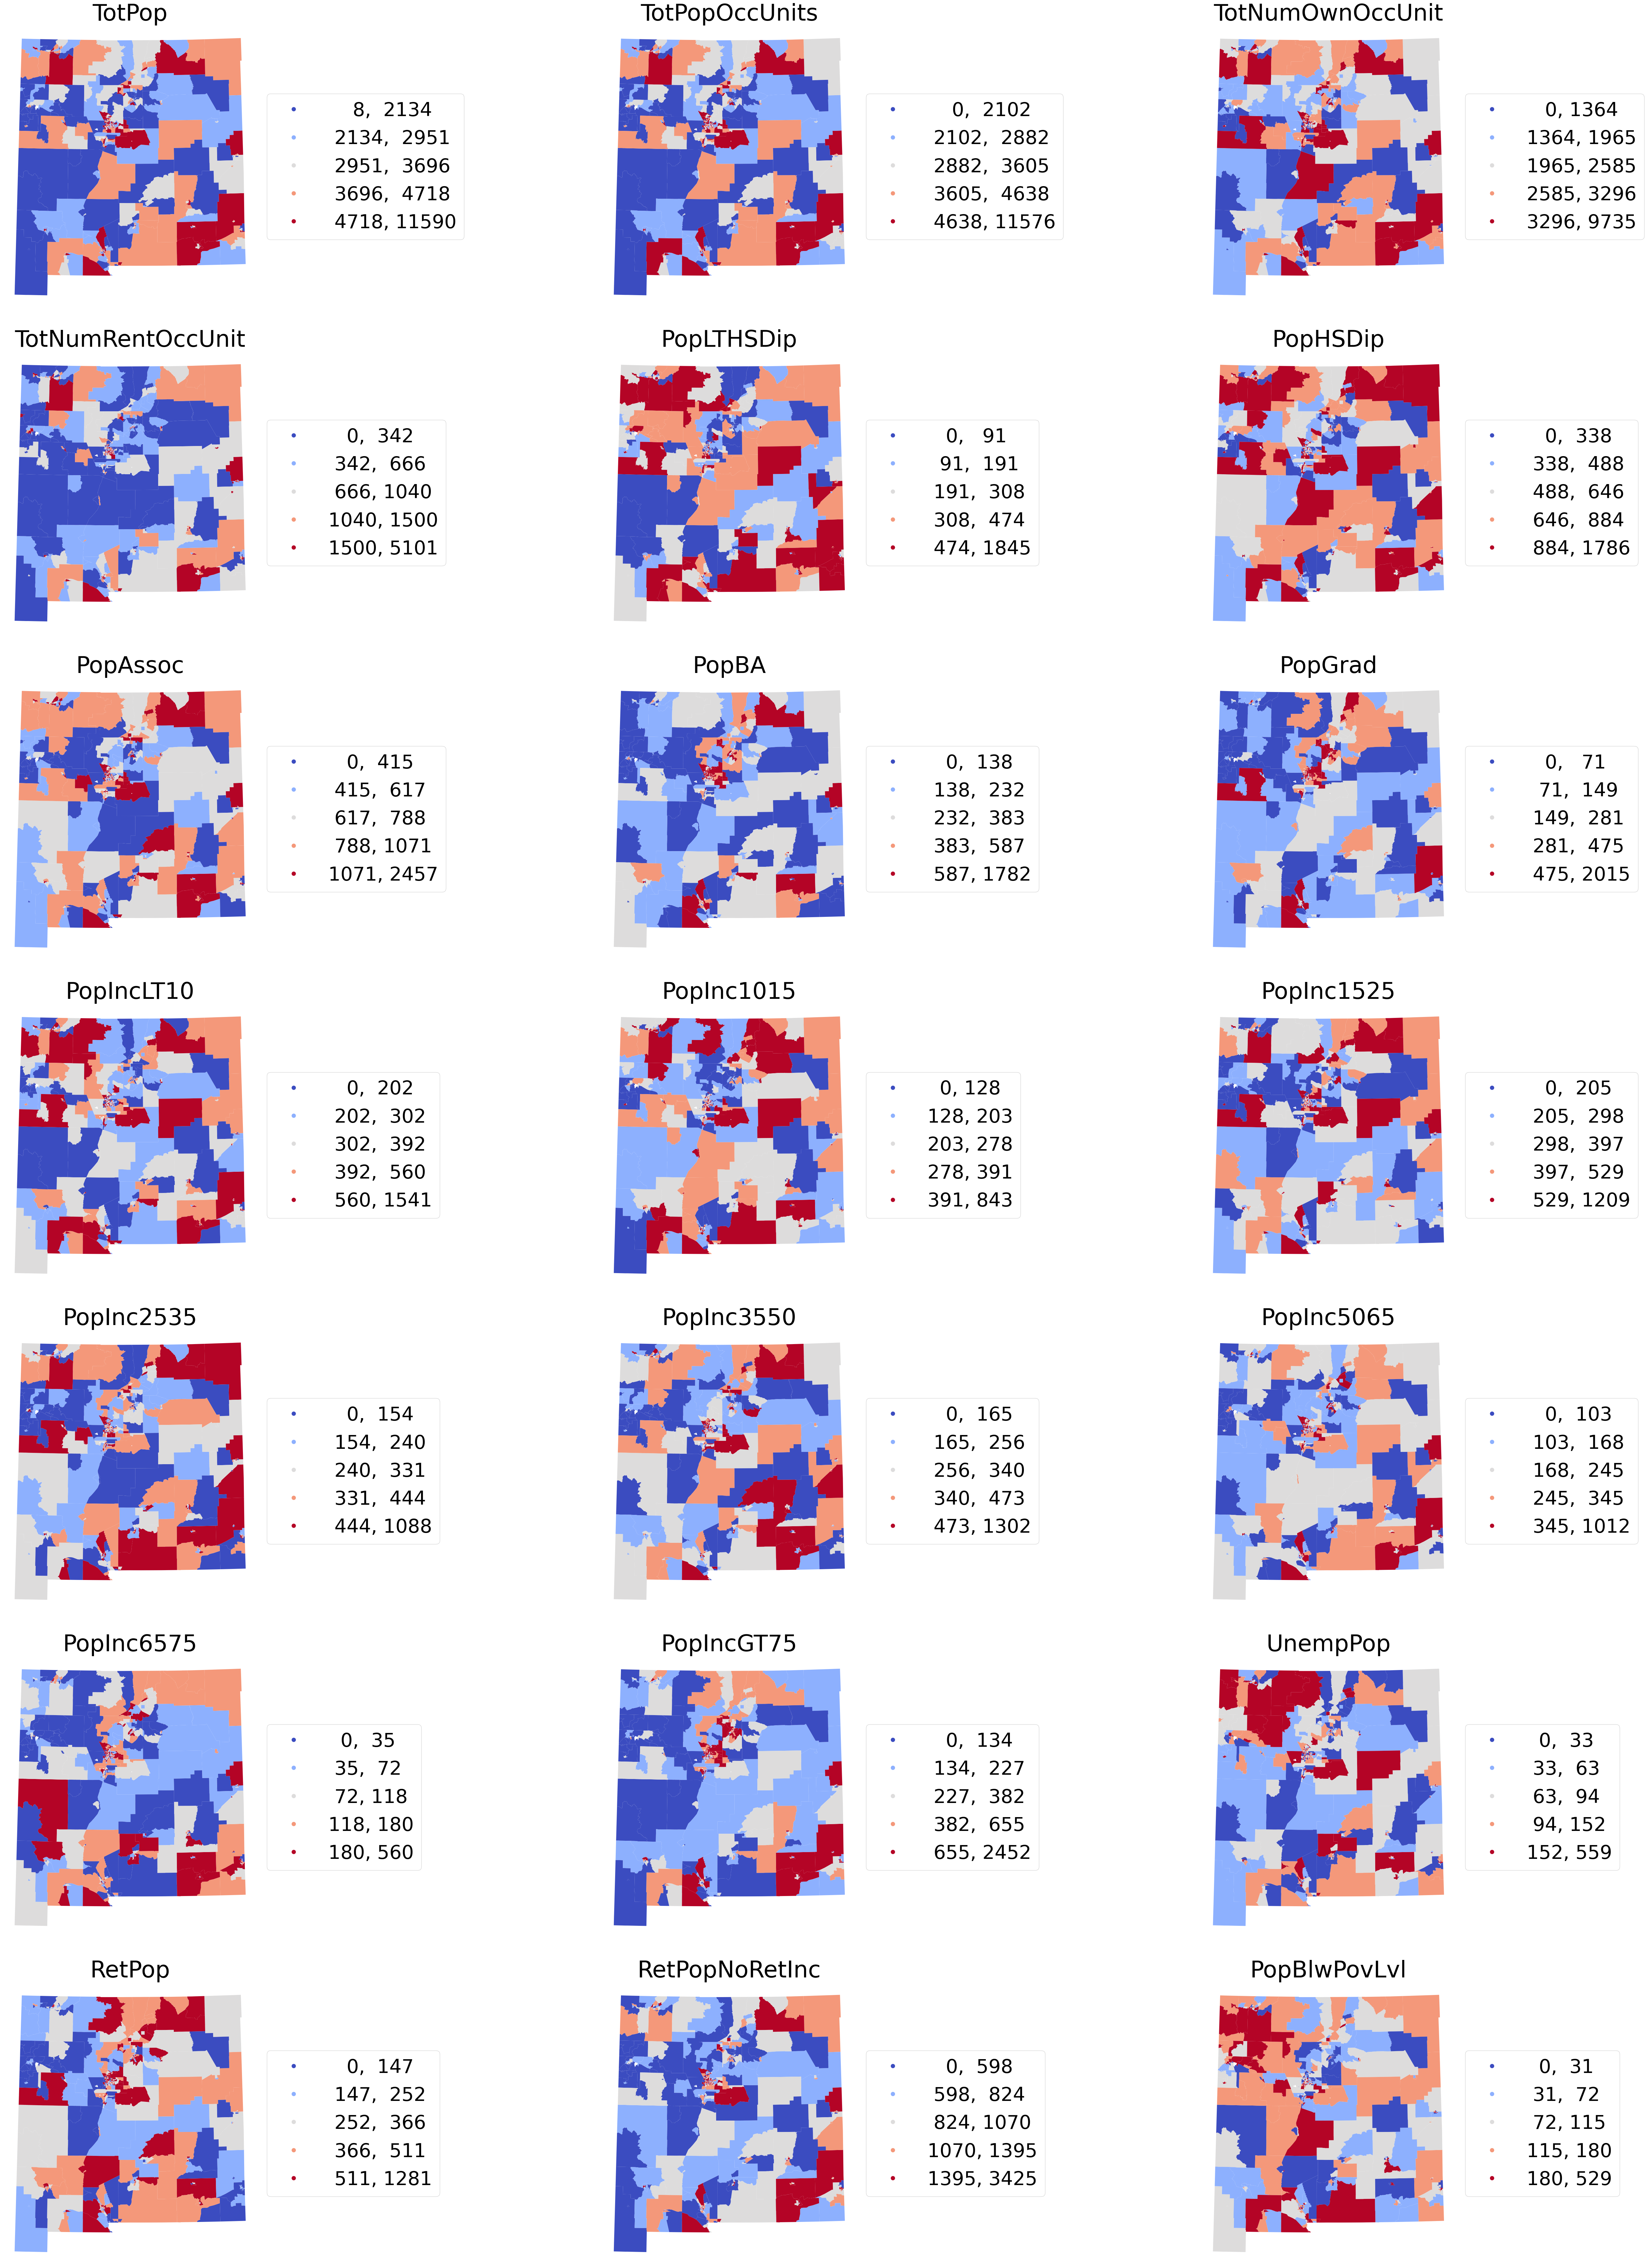

In [4]:
# Setting up the figure using subplots to map each of the extracted variables
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(75,75), layout='tight')

axes = axes.flatten()

# Setting the font size
plt.rcParams['font.size'] = '45'
plt.style.use('seaborn-v0_8-dark-palette')

# Plotting each of the extracted variables in a subplot
for ind, col in enumerate(geo_demo_rn):
    ax = axes[ind]
    nm_merge2.plot(column=col,
                  ax = ax, scheme = "quantiles", linewidth=0, cmap="coolwarm", 
                    legend=True, legend_kwds={'loc': 'center left','bbox_to_anchor':(1,0.5),'fmt': "{:.0f}"}
                 ) 
    ax.set_axis_off()
    ax.set_title(col)
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()
    
    

In [4]:
nm_merge2.TotPop.describe()

count      604.000000
mean      3497.455298
std       1568.284603
min          8.000000
25%       2368.000000
50%       3282.500000
75%       4367.000000
max      11590.000000
Name: TotPop, dtype: float64

In [5]:
def print_stats(vars): 
    for var in vars:
        
        print(f'''
            Mean:    {var.mean():>10,.2f}
            Std Dev: {var.std():>10,.2f}
            Median:  {var.median():>10,.2f}
            Max:     {var.max():>10,.2f}
            Min:     {var.min():>10,.2f}
        ''')

In [6]:
print_stats([nm_merge2.TotPop])


            Mean:      3,497.46
            Std Dev:   1,568.28
            Median:    3,282.50
            Max:      11,590.00
            Min:           8.00
        


# Measuring spatial autocorrelation

>Test for autocorrelation with Moran's I
>
>Create the weights matrix

In [7]:
w = Queen.from_dataframe(nm_merge2, use_index=False)

In [8]:
moransi_results = [
    Moran(nm_merge2[v], w) for v in geo_demo_rn
]

In [9]:
moransi_results = [
    (v, res.I, res.p_sim) 
    for v, res in zip(geo_demo_rn, moransi_results)
]

In [10]:
table = pd.DataFrame(
    moransi_results, columns=["Vars", "Moran's I", "P-value"]
).set_index("Vars")
table.sort_values(by="Moran's I", ascending=False).head()

Moran's I  P-value
Vars                                 
PopGrad             0.436022    0.001
PopBA               0.427239    0.001
PopIncGT75          0.417523    0.001
PopLTHSDip          0.372088    0.001
TotNumRentOccUnit   0.285198    0.001

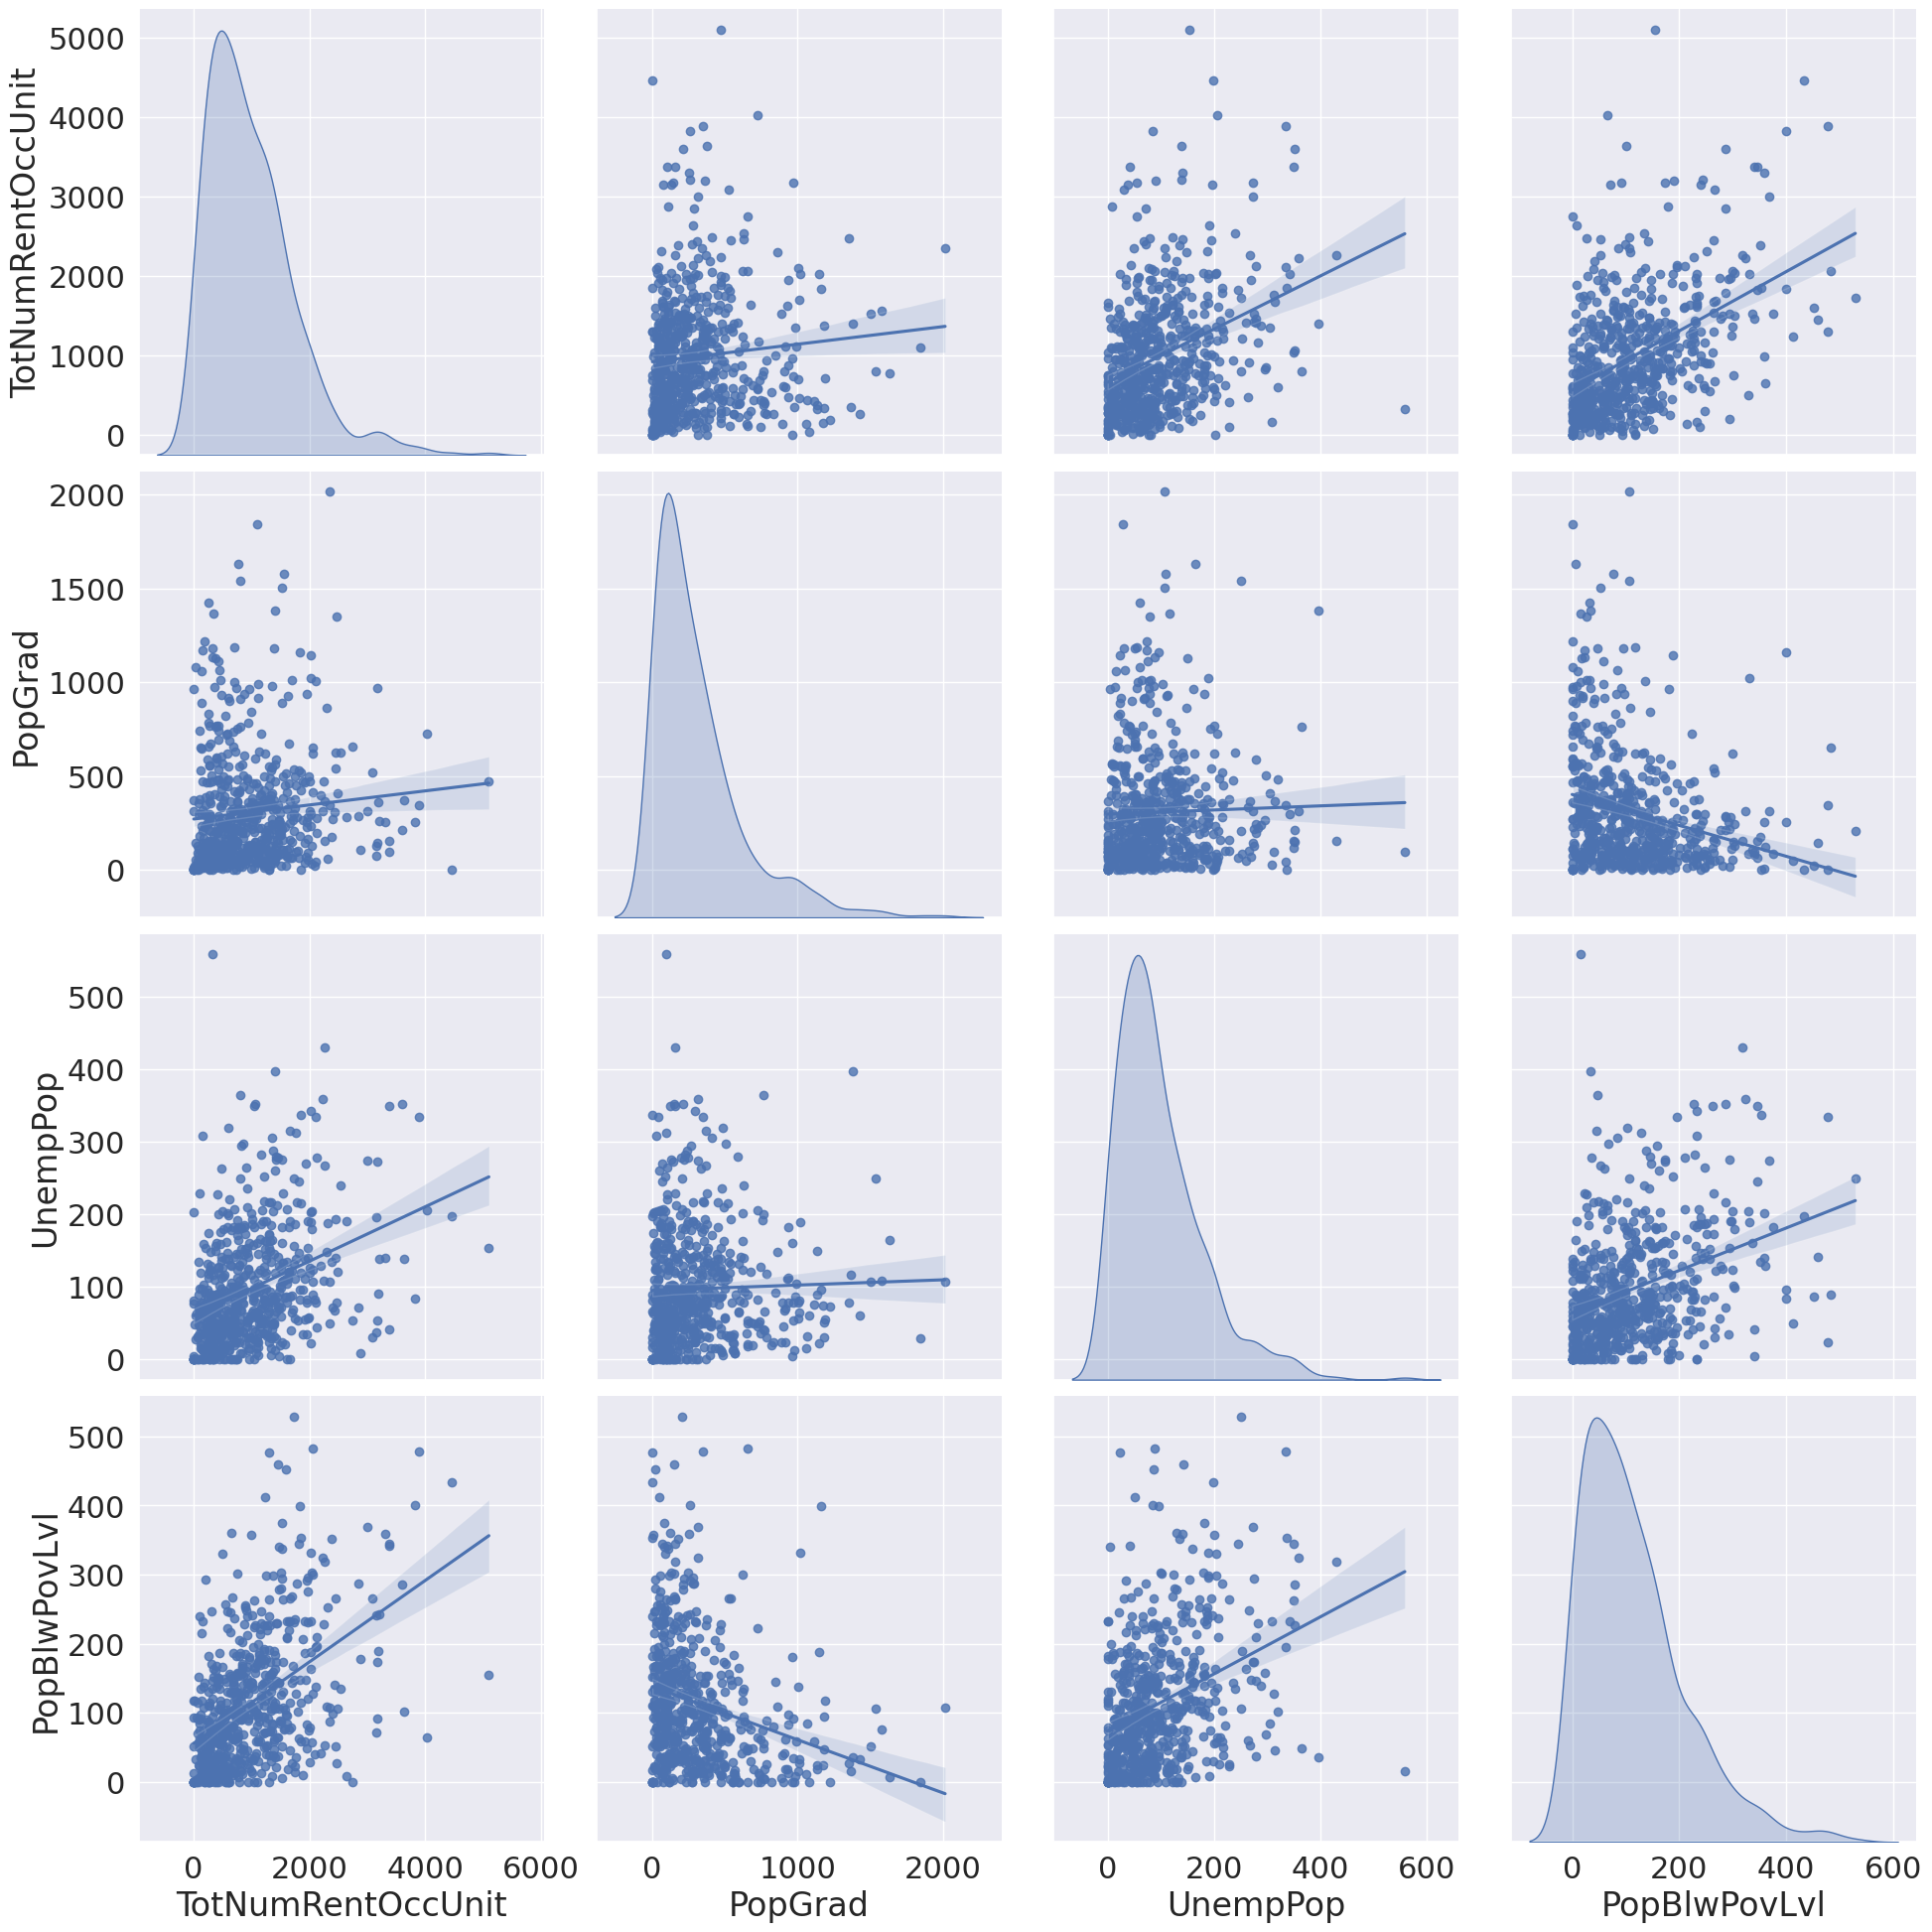

In [11]:
sns.set(font_scale=2)

# Given we have 25 variables in the data set to explore, this will be way to many plots to visually inspect. Lets inspect just a handful
sel_vars = [
    "TotNumRentOccUnit", #"Total number of renter occupied units"
    "PopGrad", #"Population with a graduate degree"
    "UnempPop", #"Population in labor force and unemployed"
    "PopBlwPovLvl" #"Population with income below poverty level in past 12 months"
]

pplt = sns.pairplot(
    nm_merge2[sel_vars], kind="reg", diag_kind="kde",
    height=5, 
)
plt.show()

In [12]:
nm_merge2_ng = nm_merge2.drop(columns=['geometry'])

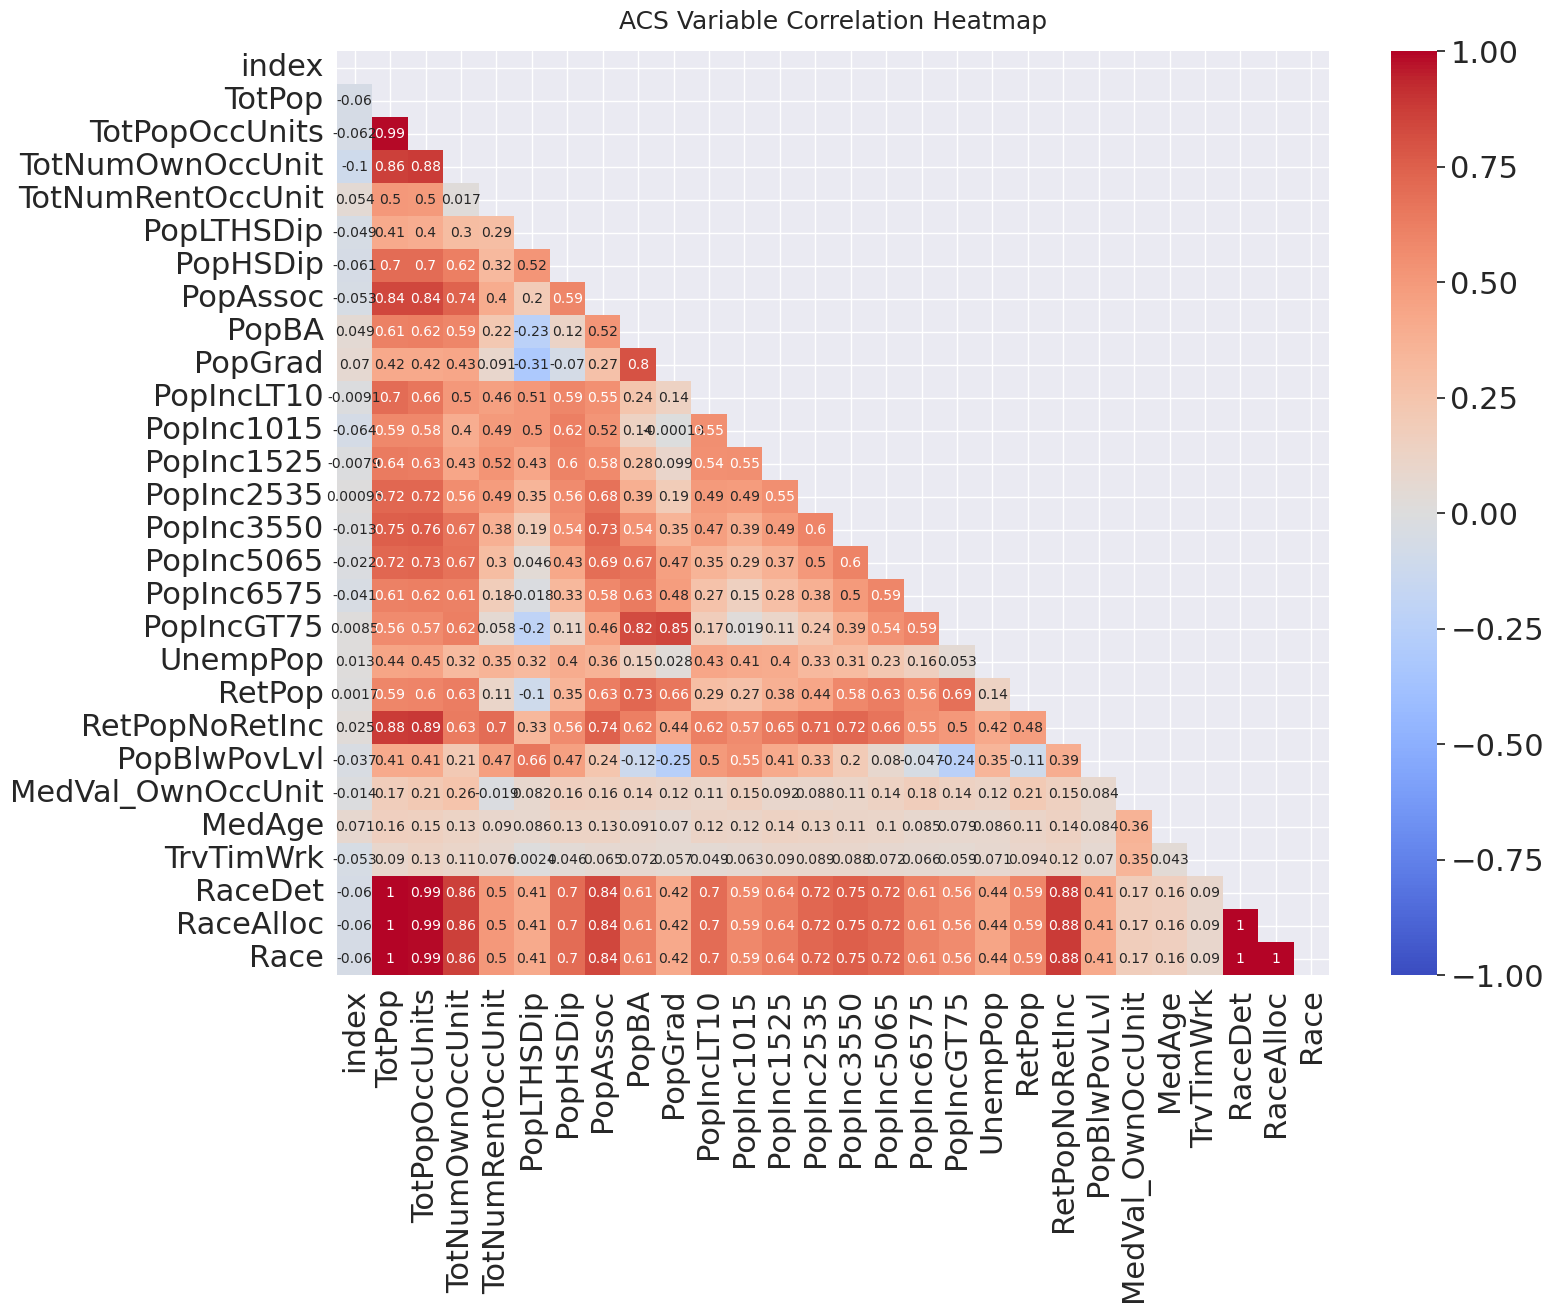

In [13]:
plt.figure(figsize=(16,12))
plt.rcParams['font.size'] = '10'
mask = np.triu(np.ones_like(nm_merge2_ng.corr(), dtype=np.bool_)) 
heatmap = sns.heatmap(
    nm_merge2_ng.corr(), mask=mask, 
    vmin=-1, vmax=1, annot=True, cmap='coolwarm'
)
heatmap.set_title('ACS Variable Correlation Heatmap', 
                 fontdict=dict(fontsize=18), pad=16);

In [14]:
nm_merge2_ng.corr()

index    TotPop  TotPopOccUnits  TotNumOwnOccUnit  \
index              1.000000 -0.059849       -0.062140         -0.101569   
TotPop            -0.059849  1.000000        0.991167          0.863585   
TotPopOccUnits    -0.062140  0.991167        1.000000          0.875959   
TotNumOwnOccUnit  -0.101569  0.863585        0.875959          1.000000   
TotNumRentOccUnit  0.053913  0.500923        0.496971          0.016729   
PopLTHSDip        -0.048956  0.413249        0.398113          0.297521   
PopHSDip          -0.060895  0.700803        0.697275          0.624756   
PopAssoc          -0.053068  0.836756        0.837124          0.742120   
PopBA              0.049385  0.609595        0.617520          0.588349   
PopGrad            0.069614  0.415813        0.420926          0.434360   
PopIncLT10        -0.009102  0.700709        0.660148          0.502985   
PopInc1015        -0.063596  0.585158        0.580453          0.395005   
PopInc1525        -0.007899  0.638439        0.629752          0.434239   
PopInc2535         0.000954  0.720098        0.724971          0.561737   
PopInc3550        -0.012716  0.751950        0.762053          0.667006   
PopInc5065        -0.021837  0.722029        0.727510          0.672406   
PopInc6575        -0.041033  0.614870        0.618292          0.610792   
PopIncGT75         0.008529  0.563200        0.569386          0.623884   
UnempPop           0.012873  0.444082        0.447204          0.318428   
RetPop             0.001711  0.589375        0.599236          0.629965   
RetPopNoRetInc     0.025010  0.877608        0.886134          0.634352   
PopBlwPovLvl      -0.036572  0.413305        0.411197          0.213208   
MedVal_OwnOccUnit -0.013733  0.172414        0.213402          0.256582   
MedAge             0.070575  0.156535        0.152765          0.125840   
TrvTimWrk         -0.053355  0.090412        0.129838          0.105846   
RaceDet           -0.059849  1.000000        0.991167          0.863585   
RaceAlloc         -0.059849  1.000000        0.991167          0.863585   
Race              -0.059849  1.000000        0.991167          0.863585   

                   TotNumRentOccUnit  PopLTHSDip  PopHSDip  PopAssoc  \
index                       0.053913   -0.048956 -0.060895 -0.053068   
TotPop                      0.500923    0.413249  0.700803  0.836756   
TotPopOccUnits              0.496971    0.398113  0.697275  0.837124   
TotNumOwnOccUnit            0.016729    0.297521  0.624756  0.742120   
TotNumRentOccUnit           1.000000    0.289971  0.321392  0.400136   
PopLTHSDip                  0.289971    1.000000  0.518108  0.202029   
PopHSDip                    0.321392    0.518108  1.000000  0.593632   
PopAssoc                    0.400136    0.202029  0.593632  1.000000   
PopBA                       0.221573   -0.233980  0.117610  0.519419   
PopGrad                     0.091098   -0.314261 -0.069573  0.271796   
PopIncLT10                  0.463492    0.505729  0.589037  0.545532   
PopInc1015                  0.492551    0.504789  0.617975  0.516354   
PopInc1525                  0.524156    0.434086  0.601695  0.577004   
PopInc2535                  0.492164    0.346622  0.564384  0.675810   
PopInc3550                  0.379657    0.189166  0.544876  0.725856   
PopInc5065                  0.298345    0.045681  0.425734  0.689496   
PopInc6575                  0.182801   -0.017876  0.331439  0.582876   
PopIncGT75                  0.057880   -0.203553  0.106396  0.460092   
UnempPop                    0.354116    0.319691  0.399135  0.364293   
RetPop                      0.108811   -0.103973  0.350571  0.629582   
RetPopNoRetInc              0.695588    0.330123  0.562893  0.744777   
PopBlwPovLvl                0.468765    0.657153  0.467342  0.239805   
MedVal_OwnOccUnit          -0.019240    0.081509  0.162158  0.155086   
MedAge                      0.090267    0.085707  0.125928  0.132118   
TrvTimWrk                   0.076350    0.0023

>Scale the variables for modeling

In [15]:
nm_merged_scaled = robust_scale(nm_merge2[geo_demo_rn])
nm_merged_scaled

array([[-0.04427214, -0.01913249,  0.17200512, ...,  0.5532646 ,
        -0.28101072, -0.62579281],
       [ 0.20835418,  0.24557725,  0.34561179, ...,  0.        ,
         0.56431853, -0.4397463 ],
       [-0.56103052, -0.59153453, -0.65438821, ..., -0.85223368,
        -0.31316998,  0.63424947],
       ...,
       [ 0.13281641,  0.16118464,  0.46668802, ...,  0.23367698,
        -0.31776417, -0.34672304],
       [-1.14332166, -1.69335605, -1.46796925, ..., -1.02749141,
        -1.44333844, -0.78646934],
       [-0.16433217, -0.14493513, -0.2905189 , ...,  0.09278351,
         0.04058193,  0.03382664]])

# K-means geodemographic clustering

In [16]:
from sklearn.cluster import KMeans

>Find the elbow point to determine number of clusters

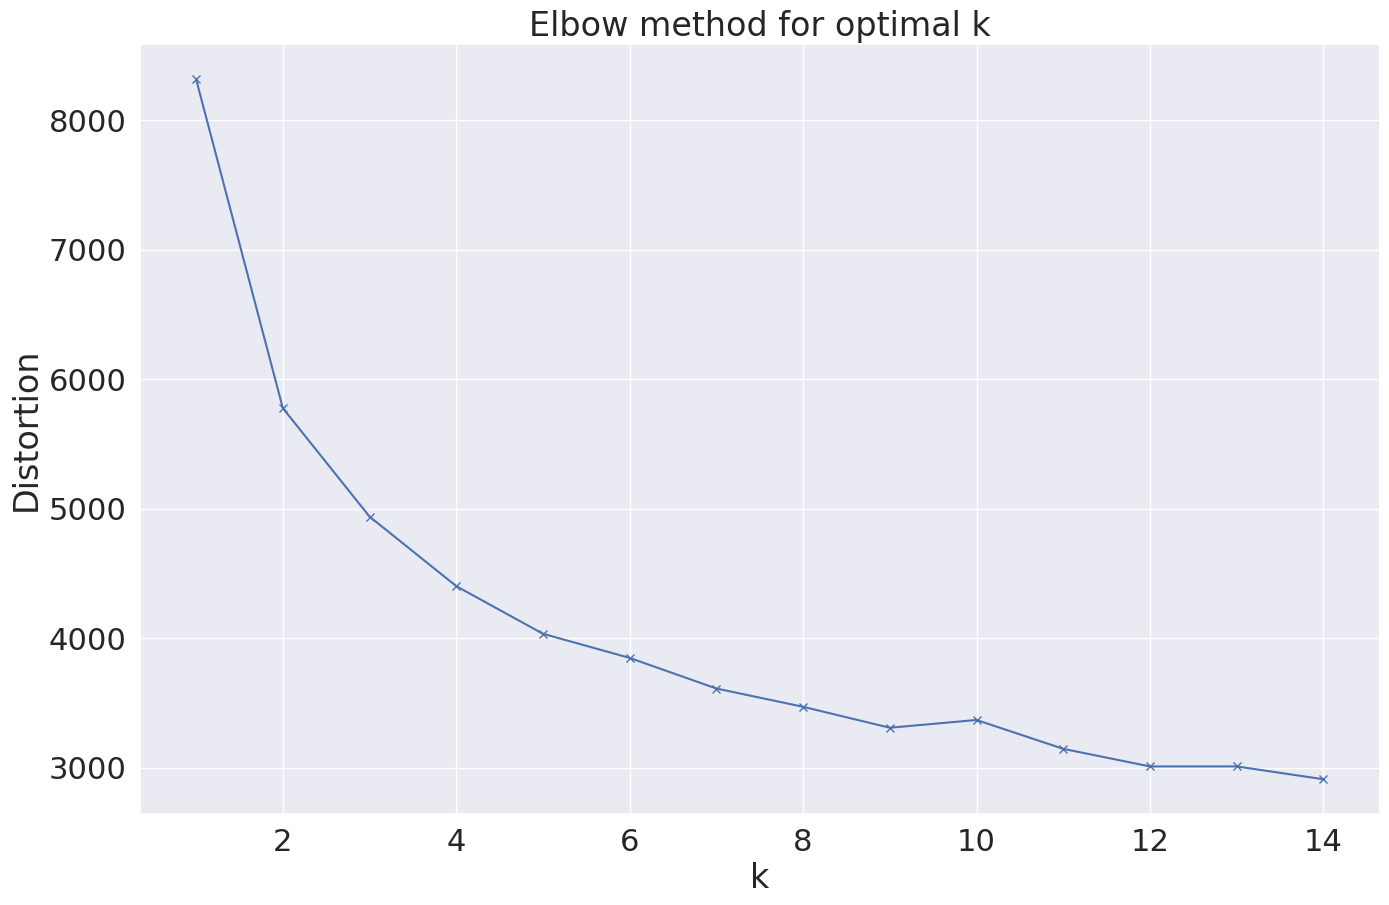

In [17]:
distortions = []
K = range(1,15)
for k in K: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(nm_merged_scaled)
    distortions.append(kmeans.inertia_)
plt.figure(figsize=(16,10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow method for optimal k');

In [18]:
kmeans = KMeans(n_clusters=5)
kmeans_5 = kmeans.fit(nm_merged_scaled)
kmeans_5.labels_

array([3, 3, 2, 0, 2, 0, 0, 1, 1, 3, 2, 4, 3, 3, 3, 3, 3, 2, 3, 0, 2, 2,
       2, 0, 2, 2, 0, 3, 2, 2, 3, 3, 4, 4, 3, 4, 1, 2, 0, 3, 2, 4, 3, 1,
       3, 4, 2, 3, 2, 2, 0, 0, 3, 3, 3, 0, 3, 0, 2, 2, 1, 4, 3, 3, 1, 3,
       2, 2, 0, 0, 0, 3, 2, 2, 3, 0, 2, 0, 2, 3, 2, 2, 2, 3, 3, 2, 1, 1,
       3, 4, 1, 3, 2, 4, 3, 3, 3, 0, 2, 1, 1, 1, 2, 0, 4, 1, 1, 2, 1, 2,
       0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 3, 2, 0,
       2, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 1, 1, 3, 3, 2, 3, 2, 2, 0, 0, 2,
       2, 0, 2, 2, 2, 2, 3, 0, 0, 1, 1, 4, 2, 0, 0, 1, 0, 2, 2, 0, 3, 2,
       3, 4, 2, 2, 2, 1, 2, 3, 0, 3, 2, 0, 4, 4, 3, 3, 1, 3, 0, 0, 0, 0,
       2, 2, 1, 2, 3, 0, 3, 0, 0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 4, 3, 2,
       3, 2, 2, 3, 1, 0, 2, 0, 2, 2, 4, 1, 4, 0, 2, 4, 2, 2, 3, 0, 0, 3,
       3, 0, 2, 0, 3, 0, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 3, 3, 3, 2, 0,
       3, 2, 2, 1, 2, 2, 2, 4, 4, 3, 3, 2, 2, 0, 0, 0, 3, 0, 3, 3, 0, 3,
       2, 0, 0, 2, 2, 0, 4, 0, 2, 0, 4, 0, 3, 0, 2,

In [19]:
nm_merge2["kmeans_5_label"] = kmeans_5.labels_

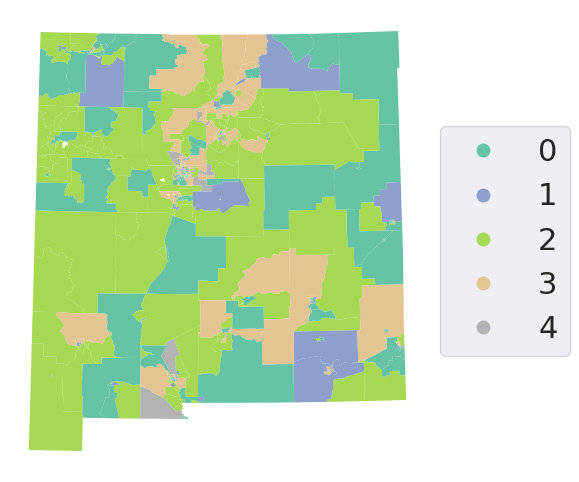

In [20]:
f, ax = plt.subplots(figsize=(6,6))
nm_merge2.plot(
    column='kmeans_5_label', 
    categorical=True, 
    legend=True, 
    lw = 0,
    ax=ax, 
    cmap='Set2', 
    legend_kwds=dict(loc='center left',
                     bbox_to_anchor=(1, 0.5), 
                     fmt='{:.0f}')
)
ax.set_axis_off()

In [21]:
abq = gpd.read_file('../../data/local/abq_shp.gpkg')

In [22]:
abq = abq.to_crs(2258)

In [23]:
abq = abq.dissolve()

In [24]:
nm_merge3 = nm_merge2.to_crs(2258)

In [25]:
nm_merge3_mask = nm_merge3.within(abq.loc[0, 'geometry'])

In [26]:
nm_merge4 = nm_merge3.loc[nm_merge3_mask]

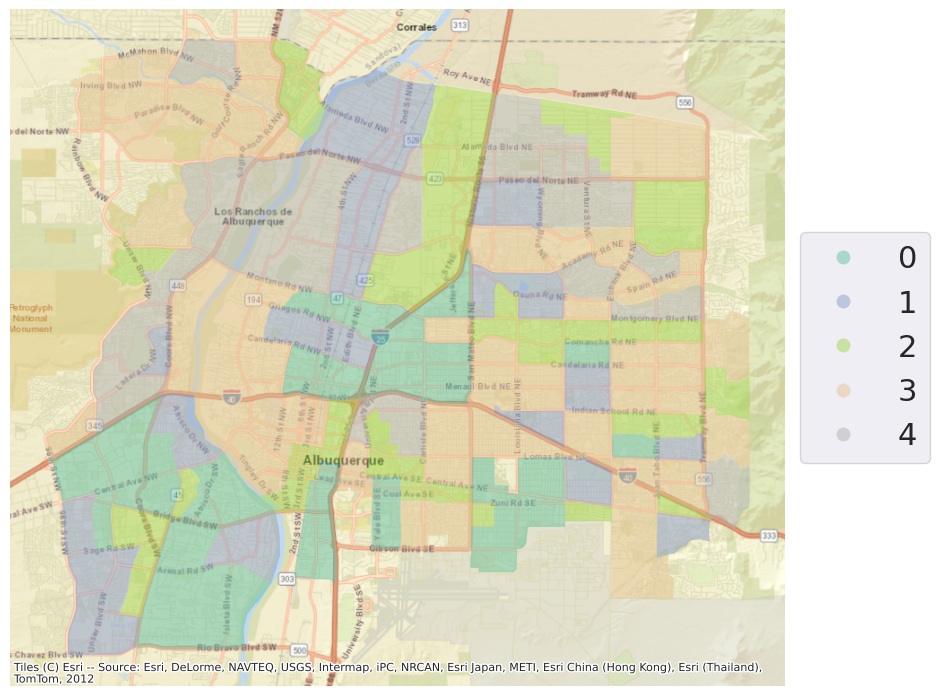

In [27]:
f, ax = plt.subplots(figsize=(10,10))
nm_merge4.plot(
    column='kmeans_5_label', 
    categorical=True, 
    legend=True, 
    lw = 0, alpha=0.5,
    ax=ax, 
    cmap='Set2', 
    legend_kwds=dict(loc='center left',
                     bbox_to_anchor=(1, 0.5), 
                     fmt='{:.0f}')
)
ax.set_axis_off()
ctx.add_basemap(ax, crs=nm_merge4.crs, source=ctx.providers.Esri.WorldStreetMap);

In [28]:
k5distr = nm_merge2.groupby("kmeans_5_label").size() 
k5distr

kmeans_5_label
0    159
1     63
2    198
3    143
4     41
dtype: int64

>Get CRS unit of measure

In [29]:
print(nm_merge2.crs.axis_info)

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9003, unit_name=US survey foot), Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9003, unit_name=US survey foot)]


>Calculate area of census tracts in sq. mi.

In [30]:
nm_merge2['area'] = (nm_merge2.geometry.area)*3.587E-8

>Dissolve tracts adnd cacluate cluster areas

In [31]:
area = nm_merge2.dissolve(by='kmeans_5_label', aggfunc='sum')['area']
print(f'The area of the clusters is {area}')

The area of the clusters is kmeans_5_label
0    36746.259806
1     9491.804848
2    57603.726311
3    16193.139089
4     1573.915411
Name: area, dtype: float64


In [32]:
tract_area = pd.DataFrame({"Num. Tracts": k5distr, "Area": area})

In [33]:
tract_area['Area_per_tract'] = tract_area['Area'] / tract_area["Num. Tracts"]

In [34]:
tract_area.reset_index(inplace=True)

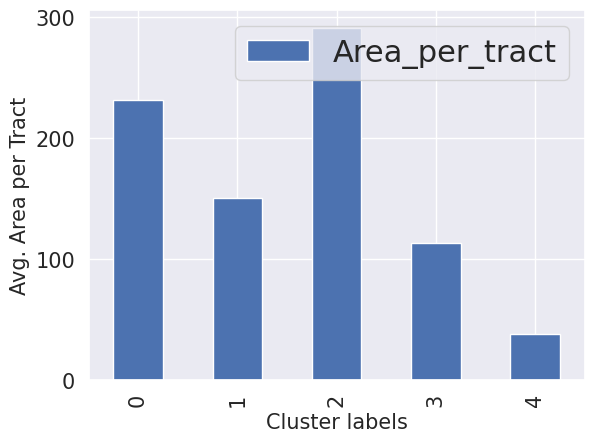

In [35]:
ax = tract_area.plot.bar(x='kmeans_5_label', y='Area_per_tract')
plt.xlabel('Cluster labels', fontsize=15)
plt.ylabel('Avg. Area per Tract', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15);

In [36]:
k5means = nm_merge2.groupby('kmeans_5_label')[geo_demo_rn].mean()
k5means.round(2)
k5means

TotPop  TotPopOccUnits  TotNumOwnOccUnit  \
kmeans_5_label                                                  
0               3677.584906     3594.352201       2331.886792   
1               5795.809524     5704.539683       3788.523810   
2               1959.621212     1880.161616       1368.267677   
3               3627.720280     3584.671329       2690.930070   
4               6239.560976     6192.414634       5083.634146   

                TotNumRentOccUnit  PopLTHSDip     PopHSDip     PopAssoc  \
kmeans_5_label                                                            
0                     1262.465409  495.377358   752.849057   742.729560   
1                     1916.015873  551.253968  1126.428571  1312.857143   
2                      511.893939  193.964646   360.398990   428.661616   
3                      893.741259  169.041958   549.937063   839.461538   
4                     1108.780488  209.439024   765.829268  1330.634146   

                      PopBA     PopGrad  PopIncLT10  ...  PopInc1525  \
kmeans_5_label                                       ...               
0                236.911950  148.867925  471.402516  ...  430.830189   
1                487.222222  313.714286  678.714286  ...  641.539683   
2                192.863636  151.191919  225.833333  ...  226.388889   
3                564.580420  513.440559  341.027972  ...  353.034965   
4               1059.000000  961.146341  562.609756  ...  443.146341   

                PopInc2535  PopInc3550  PopInc5065  PopInc6575   PopIncGT75  \
kmeans_5_label                                                                
0               336.773585  324.421384  195.000000   83.830189   227.452830   
1               533.206349  600.428571  375.015873  156.190476   488.873016   
2               172.237374  179.202020  119.984848   59.691919   206.989899   
3               325.279720  379.468531  304.594406  151.692308   643.454545   
4               434.292683  601.000000  493.414634  300.365854  1291.585366   

                  UnempPop      RetPop  RetPopNoRetInc  PopBlwPovLvl  
kmeans_5_label                                                        
0               115.383648  253.735849     1068.811321    184.270440  
1               189.698413  490.047619     1696.428571    201.682540  
2                53.792929  186.863636      550.959596     70.318182  
3                91.489510  464.846154     1066.552448     62.594406  
4               117.902439  705.536585     1727.146341     96.853659  

[5 rows x 21 columns]

In [37]:
import plotly.io as pio 
pio.renderers.default = 'iframe'

In [38]:
nm_merged_scaled_df = pd.DataFrame(nm_merged_scaled, columns=geo_demo_rn)
nm_merged_scaled_df['kmeans_5_label'] = kmeans_5.labels_ 
k5means_s = nm_merged_scaled_df.groupby('kmeans_5_label')[geo_demo_rn].mean()

In [40]:
k5means_s.round(2)

TotPop  TotPopOccUnits  TotNumOwnOccUnit  TotNumRentOccUnit  \
kmeans_5_label                                                                
0                 0.20            0.19              0.03               0.47   
1                 1.26            1.30              0.96               1.16   
2                -0.66           -0.71             -0.59              -0.33   
3                 0.17            0.19              0.26               0.07   
4                 1.48            1.55              1.79               0.30   

                PopLTHSDip  PopHSDip  PopAssoc  PopBA  PopGrad  PopIncLT10  \
kmeans_5_label                                                               
0                     0.81      0.47      0.09  -0.20    -0.20        0.42   
1                     1.00      1.38      1.17   0.49     0.31        1.13   
2                    -0.16     -0.48     -0.50  -0.32    -0.19       -0.42   
3                    -0.24     -0.02      0.27   0.70     0.92       -0.03   
4                    -0.11      0.50      1.20   2.06     2.29        0.73   

                ...  PopInc1525  PopInc2535  PopInc3550  PopInc5065  \
kmeans_5_label  ...                                                   
0               ...        0.33        0.26        0.12       -0.06   
1               ...        1.13        1.13        1.28        0.84   
2               ...       -0.45       -0.47       -0.49       -0.44   
3               ...        0.03        0.21        0.35        0.49   
4               ...        0.37        0.69        1.28        1.44   

                PopInc6575  PopIncGT75  UnempPop  RetPop  RetPopNoRetInc  \
kmeans_5_label                                                             
0                    -0.06       -0.18      0.40   -0.16            0.19   
1                     0.57        0.44      1.18    0.66            1.15   
2                    -0.27       -0.23     -0.26   -0.39           -0.60   
3                     0.53        0.81      0.14    0.57            0.19   
4                     1.83        2.35      0.42    1.40            1.20   

                PopBlwPovLvl  
kmeans_5_label                
0                       0.77  
1                       0.92  
2                      -0.19  
3                      -0.26  
4                       0.03  

[5 rows x 21 columns]

In [41]:
import plotly.graph_objects as go

In [43]:
categories = k5means_s.columns
fig = go.Figure() 
for g in k5means_s.index: 
    fig.add_trace(go.Scatterpolar(
        r = k5means_s.loc[g].values, 
        theta=categories, 
        fill='toself', 
        name=f'cluster #{g}'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True, 
            range=[-2,5]
        )
    ), 
    showlegend=True, 
    title='KMeans Cluster Radial Plot', 
    title_x = 0.5
)

fig.show()

>Agglomerative Clustering

In [44]:
from sklearn.cluster import AgglomerativeClustering

In [45]:
model = AgglomerativeClustering(
    linkage='ward', connectivity=w.sparse, n_clusters=5
)
model.fit(nm_merged_scaled)

AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3622 stored elements and shape (604, 604)>,
                        n_clusters=5)

In [47]:
nm_merge2['ward5_label'] = model.labels_ 
nm_merged_scaled_df['ward5_label'] = model.labels_

In [46]:
nm_merge2['ward5wgt_label'] = model.labels_
nm_merged_scaled_df["ward5wgt_label"] = model.labels_

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(12,6))
ax = axs[0,0]

nm_merge2.plot(
    column='kmeans_5_label', 
    categorical=True, 
    cmap='Set2', 
    legend=True, 
    legend_kwds=dict(loc='center left', bbox_to_anchor=(1,0.5), fmt="{:.0f}"), 
    lw=0, 
    ax=ax
)
ax.set_axis_off() 
ax.set_title("KMeans with $k=5$")

ax = axs[0,1]
nm_merge2.plot(
    column='ward5wgt_label', 
    categorical=True, 
    cmap='Set3', 
    legend=True, 
    legend_kwds=dict(loc='center left', bbox_to_anchor=(1,0.5), fmt="{:.0f}"), 
    lw=0, 
    ax=ax
    
)
ax.set_axis_off()

# Add the title
ax.set_title("AHC with $k=5$")
ax=axs[1,0]



In [58]:
?pd.DataFrame

Init signature:
pd.DataFrame(
    data=None,
    index: 'Axes | None' = None,
    columns: 'Axes | None' = None,
    dtype: 'Dtype | None' = None,
    copy: 'bool | None' = None,
) -> 'None'
Docstring:     
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, dataclass or list-like objects. If
    data is a dict, column order follows insertion-order. If a dict contains Series
    which have an index defined, it is aligned by its index. This alignment also
    occurs if data is a Series or a DataFrame itself. Alignment is done on
    Series/DataFrame inputs.

    If data is a list of dicts, column order follows 